# Individual Assignment - 30412

Carlo Antonio Patti - 3134395

<table align="left">
  <td>
    <a href="https://colab.research.google.com/drive/1ohG5S4XwqS0w5IdjkkTDh4Zc4BQ35xbH#scrollTo=31bc1dea" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>

## Task description

This dataset is composed of **1100 samples** with **30 features** each. The first column
is the sample id. The second column in the dataset represents the label. There
are 3 possible values for the labels. The remaining columns are numeric
features.

Notice that the classes are **unbalanced**: some labels are more frequent than
others. You need to decide whether to take this into account, and if so how.

Your task is the following: you should compare the performance of a Support-
Vector Machine (implemented by `sklearn.svm.LinearSVC`) with that of Logistic
Regression (implemented by `sklearn.linear_model.LogisticRegression`). Try to
**optimize both algorithms' parameters** and determine which one is best for this
dataset. At the end of the analysis, you should have chosen an algorithm and its
optimal set of parameters: **write this choice explicitly** in the conclusions of
your notebook.

Your notebook should detail the procedure you have used to choose the optimal
parameters (graphs are a good idea when possible/sensible).

The notebook will be evaluated not only based on the final results, but also on
the procedure employed, which should balance practical considerations (one may
not be able to exhaustively explore all possible combinations of the parameters)
with the desire for achieving the best possible performance in the least amount
of time.

Bonus points may be assigned for particularly clean/nifty code and/or well-
presented results.

You are also free to attempt other strategies beyond the one in the assignment
(which however is mandatory!).


## Importing required packages

Let's start by importing some very common libraries which might be useful later

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

I uploaded the data on my github to make import easier from colab or any other environment, without having to mount any drive.

In [2]:
import requests
import io

url = "https://raw.githubusercontent.com/TheCodingCvrlo/assignment_30412/main/mldata.csv"

download = requests.get(url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [3]:
# use this if running locally, with this notebook and the csv file in the same folder

# filepath = os.path.join(os.getcwd(), 'mldata_0013134395.csv')
# df = pd.read_csv(filepath)

## Exploring the Dataset

Descriptive statistics and some visualizations follow. Some cells are commented to highlight only the most important info.

In [4]:
df.head()

,Unnamed: 0,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
0,0,2,4.833531,0.542011,-0.984598,0.133743,0.001955,-1.123050,1.127543,-0.915878,...,-2.532471,1.218061,1.501915,1.462644,-0.366133,-0.666049,3.262910,1.936256,-0.968280,-1.711473
1,1,0,4.041437,0.043255,0.818773,1.509510,0.445574,0.714476,1.253506,0.607898,...,-1.412795,1.893384,1.760497,0.535397,0.299378,0.390798,1.286962,2.115100,1.815018,1.938802
2,2,1,-5.022803,0.905509,-1.177129,0.242822,-1.270033,-1.811686,-1.006391,0.531494,...,4.604576,0.727504,0.788163,0.277626,1.602586,-0.573288,0.582831,0.746376,-2.561164,1.708863
3,3,0,8.142643,0.188563,-0.047802,-0.315394,-1.813394,1.381458,0.677761,0.395829,...,-3.260434,3.220630,-1.293879,2.016155,-0.574672,-0.611484,5.060627,0.439937,4.916851,-1.531910
4,4,2,5.054923,-0.284502,-1.646744,-0.279093,0.314746,-0.205413,-0.266329,-0.465928,...,1.680388,-0.198763,0.492470,2.196284,-0.719854,-0.461862,-0.654043,3.561839,2.440038,-1.571913


In [5]:
df.drop('Unnamed: 0',axis = 1, inplace = True) # I immediately drop the redundant indexes

In [6]:
# df.info()

In [7]:
# df.describe()

Some sample histograms follow, the data is already standardized aside from the scale, hence it seemed a bit visually heavy to show all 30 distributions.

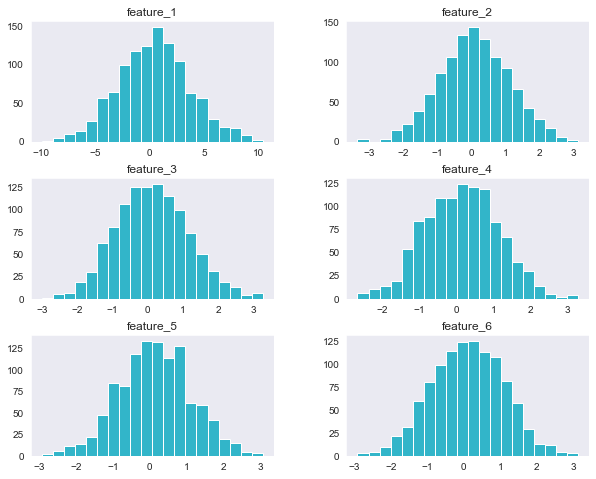

In [8]:
sns.set_style('dark')
df.iloc[:,1:7].hist(figsize = (10,8),color="#32B5C9", ec="white", grid=False, bins = 20)

#uncomment this and comment previous lline to see all of the histograms
# df.hist(figsize = (10,8),color="#32B5C9", ec="white", grid=False, bins = 20) 

plt.show()

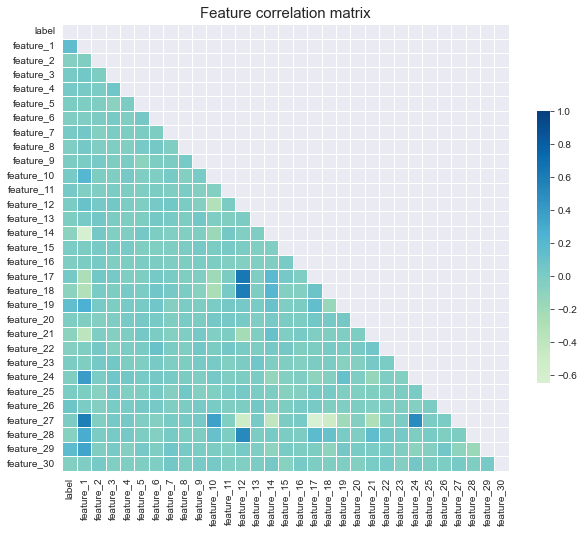

In [9]:
cm = df.corr()
plt.figure(figsize = (10,10))
mask = np.triu(np.ones_like(cm, dtype=bool))
sns.heatmap(cm, mask=mask, cmap= 'GnBu', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Feature correlation matrix', fontsize = 15)
plt.show()

### Conclusions from preliminary analysis:
* No missing values
* All numerical features, normally distributed. Not much cleaning to be done.
* The scale of the features is heterogeneous --> this might affect performance --> standardize!
* Some features are correlated, hence performing PCA on the dataset might help.
* There is an unbalance in the number of samples from the three categories.

## Train/Test Split

In [10]:
df['label'].value_counts(normalize = True)

0    0.495455
1    0.297273
2    0.207273
Name: label, dtype: float64

### Problem:
* Even though the imbalance isn't huge, the results are likely to be a bit biased towards the first category.

### Solutions:
* Using adjusted performance metrics for cross-validation (e.g. _weighted f1 score_)
* Augmenting the data for the latter categories (Oversampling/Undersampling) (at the end of the notebook)



First, a stratified split wrt the labels helps in keeping the ratio of labels in the train and test set consistent

In [11]:
from sklearn.model_selection import train_test_split


strat_train_set, strat_test_set = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state = 42)

In [12]:
pd.DataFrame({
    'Overall': df['label'].value_counts(normalize = True),
    'Overall (abs)': df['label'].value_counts(), 
    'Test': strat_test_set['label'].value_counts(normalize = True),
    'Test(abs)': strat_test_set['label'].value_counts(), 
    'Train' : strat_train_set['label'].value_counts(normalize = True),
    'Train (abs)' : strat_train_set['label'].value_counts()
})

,Overall,Overall (abs),Test,Test(abs),Train,Train (abs)
0,0.495455,545,0.495455,109,0.495455,436
1,0.297273,327,0.295455,65,0.297727,262
2,0.207273,228,0.209091,46,0.206818,182


In [13]:
# this both removes labels from the features and assigns them to a new variable
train_labels = strat_train_set.pop('label')
test_labels = strat_test_set.pop('label')

# Preprocessing

Based on the previous findings, the data is going to be standardized to have all features in the same scale, and PCA is going to be applied to get rid of correlation among features.

During cross-validation performance with/without scaling and PCA will be compared.

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

train_scaled = scaler.fit_transform(strat_train_set)

## PCA

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.8)

train_pca_base = pca.fit_transform(train_scaled)

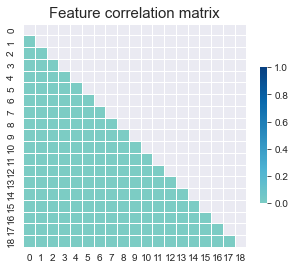

In [16]:
cm_pca = pd.DataFrame(train_pca_base).corr()
plt.figure(figsize = (5,5))
mask = np.triu(np.ones_like(cm_pca, dtype=bool))
sns.heatmap(cm_pca, mask=mask, cmap= 'GnBu', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Feature correlation matrix', fontsize = 15)
plt.show()

After standardization and PCA, the features are not correlated at all, and we can proceed with model selection. However, let's first pack both steps in a single pipeline.

In [17]:
from sklearn.pipeline import Pipeline

prep_pline = Pipeline([
    ('Scaler', StandardScaler()),
    ('pca', PCA())
])

prep_pline.fit(strat_train_set)

Pipeline(steps=[('Scaler', StandardScaler()), ('pca', PCA())])

## PCA Optimization

We now want to fine-tune the PCA, in order to find out how much the number of components influences the performance of our classifier.

In [18]:
from sklearn.metrics import cohen_kappa_score, classification_report, f1_score # these will be needed later
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score

def get_cum_var(exp_var): # takes single-feature explained variance and returns cumulative values
    cum_var = exp_var.copy()
    for i in range(len(exp_var)-1):
        cum_var[i+1:] += exp_var[i]
    return cum_var



def optimize_pca(estimator, X, Y, params_list, scaled = False):
    
    scores = [] # initialize scores list
    
    if not scaled:
        X = StandardScaler.fit_transform(X).copy() # prepare df for PCA
        
    for k in params_list:
        
        pca = PCA(n_components = k) # create pca instance, with k components
        
        X_pca = pca.fit_transform(X)
        
        estimator.fit(X_pca, Y)
        preds = estimator.predict(X_pca)
        
        score = f1_score(Y, preds, average = 'weighted')
        scores.append([k,score]) # record score and number of components used
        
        cum_var = get_cum_var(pca.explained_variance_ratio_)
        
    return scores,  cum_var #return the weighted f1 scores and the cumulative explained variance for each threshold
        

We proceed by fitting two very simple classifiers to the training set, gradually increasing the number of components.

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC as LSVC

basic_classifier_1 = LogisticRegression(multi_class = 'ovr')
basic_classifier_2 = LSVC(dual = False) # from the doc: "Prefer dual=False when n_samples > n_features."

params_list = [i for i in range(1,31)]

pca_scores_1, exp_var_1 = optimize_pca(basic_classifier_1, train_scaled, train_labels,params_list = params_list, scaled = True)
pca_scores_2, exp_var_2 = optimize_pca(basic_classifier_2, train_scaled, train_labels,params_list = params_list, scaled = True)

In [20]:
# pack all the scores in two dataframes
scores_1_df = pd.DataFrame(pca_scores_1, columns = ['n components', 'weighted f1'])
scores_1_df['explained variance'] = exp_var_1

scores_2_df = pd.DataFrame(pca_scores_2, columns = ['n components', 'weighted f1'])
scores_2_df['explained variance'] = exp_var_2


# scores_1_df.T # uncomment this to visualize all the scores in a dataframe
# scores_2_df.T

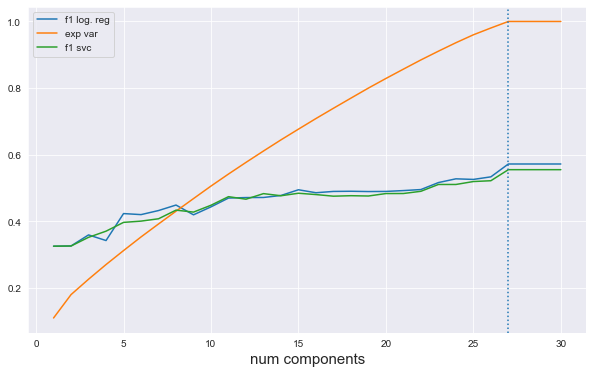

In [21]:
# plot f1 scores and explained variance
sns.set_style('darkgrid')
plt.figure(figsize = (10,6))
plt.plot(scores_1_df['n components'], scores_1_df['weighted f1'],label = 'f1 log. reg')
plt.plot(scores_1_df['n components'], scores_1_df['explained variance'], label = 'exp var')
plt.plot(scores_2_df['n components'], scores_2_df['weighted f1'], label = 'f1 svc')
plt.xlabel('num components', fontsize = 15)
plt.axvline(27, linestyle = ':')
plt.legend()

plt.show()

It seems that in both cases the optimal numer of components in terms of f1-score is around 27, sufficient to explain 100% of the dataset variance. With 30 features dimensionality reduction doesn't seem that necessary, but in this case we keep all the explained variance and remove correlation for free.

In [22]:
# prep_pline.get_params()
prep_pline.set_params(**{'pca__n_components':27})

Pipeline(steps=[('Scaler', StandardScaler()), ('pca', PCA(n_components=27))])

In [23]:
# train_pca = prep_pline.fit_transform(strat_train_set)

### Visual Interpretation

Let's try to see if, with a very small number of components, PCA reveals some visual pattern in the data.

In [24]:
pca_small = PCA(n_components = 2)

train_small = pca_small.fit_transform(train_scaled)

In [25]:
df_small = pd.merge(train_labels, pd.DataFrame(train_small, index = strat_train_set.index, columns = ['pca feature 1', 'pca feature 2']), left_index = True, right_index = True)

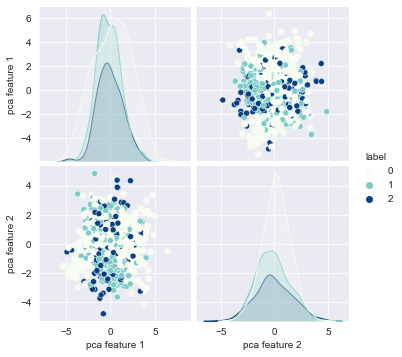

In [26]:
sns.set_style('darkgrid')
sns.pairplot(df_small, palette = 'GnBu', hue = 'label')
plt.show()

Unfortunately, it doesn't seem to be the case. There are some slightly defined clusters, especially for class 0, but nothing particularly striking.

Let's keep more components and see how the classifiers perform.

# Logistic Regression

Let's implement a simple classifier based on Logistic Regression.

In [27]:
lrc = LogisticRegression(multi_class = 'ovr')

logreg_pline = Pipeline([
    ('prep', prep_pline),
    ('estimator', lrc)
])

During Hyperparameters tuning, different combinations will be tested in terms of preprocessing

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# this is the scoring method that will be used for cross-validation in the whole notebook, both 
# in gridsearch and during model comparison
scoring_method = 'f1_weighted' 

params_grid = {
    'prep__Scaler': ['passthrough', StandardScaler()],
    'prep__pca': ['passthrough', PCA(n_components = 27)],
    'estimator__C': [10**i for i in range(-5,5)],
    'estimator__class_weight': [None, 'balanced']
}


grid_search_lr = GridSearchCV(logreg_pline, param_grid = params_grid, refit = True, scoring = scoring_method, cv = 5)

In [29]:
%%time
grid_search_lr.fit(strat_train_set, train_labels)

grid_search_lr.best_params_

CPU times: total: 37 s
Wall time: 9.35 s


{'estimator__C': 0.001,
 'estimator__class_weight': 'balanced',
 'prep__Scaler': 'passthrough',
 'prep__pca': 'passthrough'}

## Performance Metrics

In [30]:
lr_preds = grid_search_lr.predict(strat_train_set)
print(classification_report(train_labels, lr_preds))

              precision    recall  f1-score   support

           0       0.71      0.53      0.61       436
           1       0.54      0.59      0.56       262
           2       0.35      0.52      0.42       182

    accuracy                           0.55       880
   macro avg       0.53      0.55      0.53       880
weighted avg       0.59      0.55      0.56       880



# Linear SVC

Let's now implement a SVM classifier with a linear kernel.

GridSearch with different levels of regularization, preprocessing techniques, number of iterations and class weights follows.

In [31]:
lin_svc = LSVC(dual = False) #from the doc: "Prefer dual=False when n_samples > n_features."

svc_pline = Pipeline([
    ('prep', prep_pline),
    ('estimator', lin_svc)
])

In [32]:

param_grid = {
    'prep__Scaler': ['passthrough', StandardScaler()],
    'prep__pca': ['passthrough', PCA(n_components = 27)],
    'estimator__C': [0.001,0.01,0.1,1,10,100,1000],
    'estimator__max_iter' : [1000,5000,10000],
    'estimator__class_weight' : [None, 'balanced'],
}

grid_search_svc = GridSearchCV(svc_pline, cv = 5, param_grid = param_grid,refit = True, scoring = scoring_method, return_train_score = True)

In [33]:
%%time
grid_search_svc.fit(strat_train_set, train_labels)
grid_search_svc.best_params_

CPU times: total: 54.5 s
Wall time: 14 s


{'estimator__C': 0.001,
 'estimator__class_weight': None,
 'estimator__max_iter': 1000,
 'prep__Scaler': 'passthrough',
 'prep__pca': PCA(n_components=27)}

In [34]:
svc_preds = grid_search_svc.predict(strat_train_set)

In [35]:
print(classification_report(train_labels, svc_preds))

              precision    recall  f1-score   support

           0       0.64      0.75      0.69       436
           1       0.56      0.56      0.56       262
           2       0.46      0.27      0.34       182

    accuracy                           0.59       880
   macro avg       0.55      0.53      0.53       880
weighted avg       0.58      0.59      0.58       880



# Comparison

Let's now compare the performance of the models through K-fold cross-validation

In [36]:
from sklearn.model_selection import StratifiedKFold


def compare_models(estimators, labels, X, y, cv):
    
    scores_df = pd.DataFrame(columns = ['model', 'metric', 'value']) #create df to host validation scores
    
    skf = StratifiedKFold(n_splits = cv) # create skf instance
    splits = list(skf.split(X, y))

    for i in range(cv):
        X_train, X_val = X.iloc[splits[i][0]], X.iloc[splits[i][1]]  # train/validation split
        y_train, y_val = y.iloc[splits[i][0]], y.iloc[splits[i][1]]
    
        for i in range(len(estimators)): # fit and evaluate both estimators on each split

            est = estimators[i] 
            est.fit(X_train, y_train) # train model on k-1 folds
            
            preds = est.predict(X_val) #compute predictions 

            f1 = f1_score(y_val, preds, average = 'weighted') #compute performance metrics
            acc = balanced_accuracy_score(y_val, preds)
            prec = precision_score(y_val, preds, average = 'weighted')
            rec = recall_score(y_val, preds, average = 'weighted')

            metric_name = ['f1', 'accuracy', 'precision', 'recall'] # prepare to store scores
            est_name = [labels[i] for _ in range(len(metric_name))]
            score = [f1, acc, prec, rec]

            scores = pd.DataFrame({ # pack scores together
                'model': est_name,
                'metric': metric_name,
                'value' : score
            })    

            scores_df = pd.concat([scores_df, scores]) # add to scores df

    return scores_df

In [37]:
best_lr, best_svc = grid_search_lr.best_estimator_, grid_search_svc.best_estimator_
models = [best_lr, best_svc]
labels = ['Log. reg',  'Lin. SVC']

test_scores = compare_models(models, labels, strat_test_set, test_labels, cv = 10)

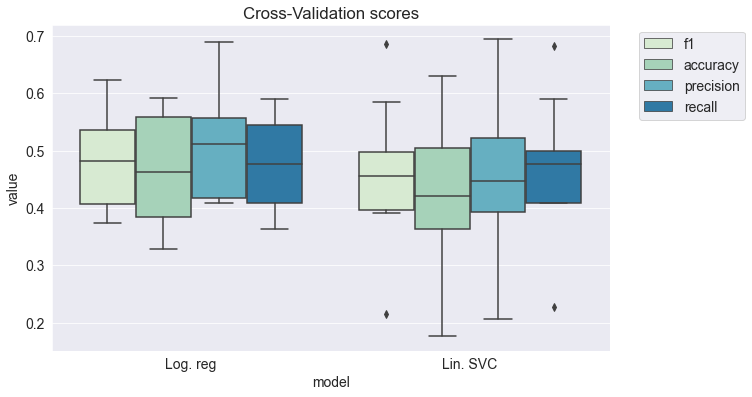

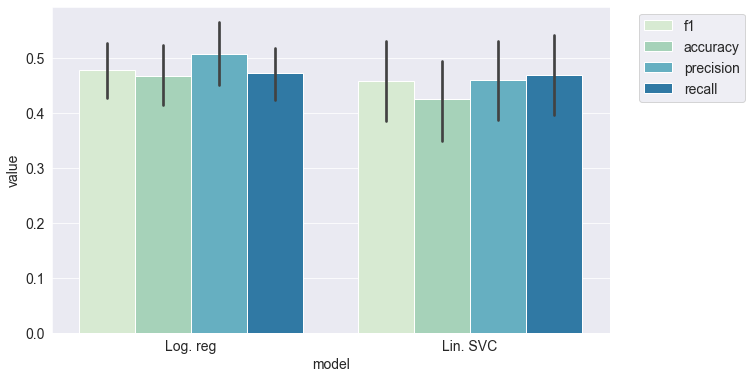

In [38]:
plt.figure(figsize = (10,6))
plt.rc('font',size = 14)
sns.set_style('darkgrid')
sns.boxplot(data = test_scores, x = 'model', y = 'value', hue = 'metric',  palette = 'GnBu')
plt.title('Cross-Validation scores')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()
plt.figure(figsize = (10,6))
sns.barplot(data = test_scores, x = 'model', y = 'value', hue = 'metric',  palette = 'GnBu')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

# Findings

Performance metrics show how, on average, Logistic Regression performs better. More precisely, it achieves a significantly higher precision score, meaning that we can "trust" its predictions to be True Positives more often.

**Remark**:

Given the multiclass setting, all metrics are averaged among every binary classification problem created by combinations of the labels.

## Generalization Performance

Since Logistic Regression seems more suited for this problem, we now evaluate its generalization performance through the test set.

In [39]:
test_preds_lr = grid_search_lr.predict(strat_test_set)

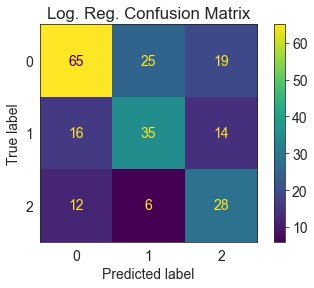

In [78]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

sns.set_style('white')
conf_m_lr = confusion_matrix(test_labels, test_preds_lr)
disp_lr = ConfusionMatrixDisplay(conf_m_lr)
disp_lr.plot()
plt.title('Log. Reg. Confusion Matrix')
plt.show()


Even the best classifier fails at consistently classifying under-represented classes. Therefore, augmenting the dataset might help us achieve a more balanced performance.

# Data Augmentation

As an alternative approach to tackle class imbalance, one can try:
* simulating a sampling process from the data distribution (Oversampling)
* removing observations from the over-represented class (Undersampling)

Since the dataset is pretty small, undersampling doesn't look like a great option. I will therefore only increase the two minor features' number of samples.

In [41]:
#uncomment and run this cell if imblearn isn't installed in your environment
#!pip install imblearn

Let's see how the performance changes using the augmented dataset.


#### DIsclaimer:
Unfortunately, sklearn doesn't support OverSampling methods as parts of a Pipeline, hence comparison between different techniques has to be done manually.

In [42]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE


sampling = {
    1 : 400, # the extent of oversampling has to be manually specified in multiclass settings
    2 : 400
}

samplers = {
    'SMOTE': SMOTE(sampling_strategy = sampling),
    'Rand': RandomOverSampler(sampling_strategy = sampling),
    'BSMOTE': BorderlineSMOTE(sampling_strategy = sampling),
    'SVMSMOTE': SVMSMOTE(sampling_strategy = sampling)
}


def compare_sampling_methods(est, features, labels, methods):
    for i in methods.keys():
        
        sampler = methods[i] #pick sampling method
        train_aug, labels_aug  = sampler.fit_resample(features, labels) #resample features and labels
        
        est.fit(train_aug,labels_aug) # train model
        preds = est.predict(features) # make predictions
        
        score = f1_score(labels, preds, average = 'weighted') #compute score
        
        print(f'{i}: {score}')


In [43]:
g_search_aug = GridSearchCV(logreg_pline, cv = 5, param_grid = param_grid,refit = True, scoring = 'f1_weighted', return_train_score = True)

In [44]:
%%time
# this cell may take a while to run
print('F1 scores for different OverSampling techniques:')
compare_sampling_methods(g_search_aug, strat_train_set, train_labels, samplers)

F1 scores for different OverSampling techniques:
SMOTE: 0.5548066302517349
Rand: 0.5507343895538773
BSMOTE: 0.5495959830096723
SVMSMOTE: 0.5396339917353806
CPU times: total: 7min 6s
Wall time: 1min 47s


No specific method stands out. Let's evaluate the model performance with augmented data and see how it generalizes.

In [116]:
sampling = {
    1 : 300, # the extent of oversampling has to be manually specified in multiclass settings
    2 : 300
}

sampler = RandomOverSampler(sampling_strategy = sampling)

train_aug, labels_aug = sampler.fit_resample(strat_train_set, train_labels)

In [117]:
%%time
g_search_aug.fit(train_aug, labels_aug)
g_search_aug.best_params_

CPU times: total: 1min 30s
Wall time: 23 s


{'estimator__C': 0.001,
 'estimator__class_weight': 'balanced',
 'estimator__max_iter': 1000,
 'prep__Scaler': 'passthrough',
 'prep__pca': 'passthrough'}

In [119]:
print(classification_report(labels_aug, g_search_aug.predict(train_aug)))

              precision    recall  f1-score   support

           0       0.66      0.52      0.58       436
           1       0.50      0.57      0.53       300
           2       0.45      0.52      0.48       300

    accuracy                           0.53      1036
   macro avg       0.53      0.54      0.53      1036
weighted avg       0.55      0.53      0.54      1036



### Performance on test set

In [120]:
preds_aug_test = g_search_aug.predict(strat_test_set)

In [121]:
print(classification_report(test_labels, preds_aug_test))

              precision    recall  f1-score   support

           0       0.65      0.49      0.56       109
           1       0.48      0.43      0.46        65
           2       0.31      0.54      0.39        46

    accuracy                           0.48       220
   macro avg       0.48      0.49      0.47       220
weighted avg       0.53      0.48      0.49       220



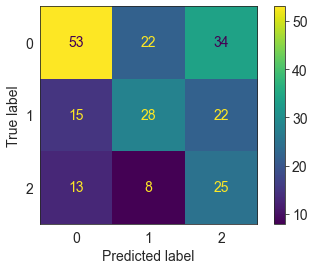

In [122]:
conf_m_aug = confusion_matrix(test_labels, preds_aug_test)
sns.set_style('white')
disp = ConfusionMatrixDisplay(conf_m_aug)
disp.plot()
plt.show()

Augmenting the dataset doesn't really translate to an increase in generalization performance.

# Conclusions

For this dataset, Logistic regression seems the most suitable model to apply, with parameters specified in the cell below. 

However, even after tuning its parameters and augmenting the dataset, we are not really able to reach adequate performance, therefore some additional models will be tested in the following lines.

In [51]:
g_search_aug.best_estimator_

Pipeline(steps=[('prep',
                 Pipeline(steps=[('Scaler', 'passthrough'),
                                 ('pca', 'passthrough')])),
                ('estimator',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=1000, multi_class='ovr'))])

# Extra: Additional Models

Below a performance comparison for some addtional classifiers:
* Random Forest
* SVM
* KNN
* Gradient Boosting
* XGB


In [52]:
# run this if xgboost is not installed in your environment
# !pip install xgboost

In [53]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

models=dict()

models["SVM Classifier"] = SVC()
models["GB Classifier"] = GradientBoostingClassifier()
models["RandomForestClassifier"] = RandomForestClassifier()
models["K-Nearest Neighbours Classsifier"] = KNeighborsClassifier()
models['XGB Classifier'] = XGBClassifier()


train_set = prep_pline.fit_transform(strat_train_set)
test_set = prep_pline.transform(strat_test_set)

for est in models:
    active_est = models[est].fit(train_set, train_labels)
    preds = active_est.predict(train_set)
    
    print(f"{est}: {f1_score(train_labels, preds, average = 'weighted')}")

SVM Classifier: 0.9138084112149532
GB Classifier: 0.9757959765575511
RandomForestClassifier: 1.0
K-Nearest Neighbours Classsifier: 0.7225954194877674
XGB Classifier: 1.0


Without tuning, most models really overfit the data. I tried ensembling through a voting regressor to check their joint performance.

# Ensembling

In [54]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ('SVM Classifier', SVC(probability = True)),
    ("K-Nearest Neighbours Classifier", KNeighborsClassifier()),
    ('XGB Classifier', XGBClassifier())
]


voting_c = VotingClassifier(estimators, voting = 'soft') #soft voting weights predictions through the degree of uncertainty of each model

In [55]:
train_set_aug, train_labels_aug = SVMSMOTE().fit_resample(train_set, train_labels)
voting_c.fit(train_set_aug, train_labels_aug)
print()

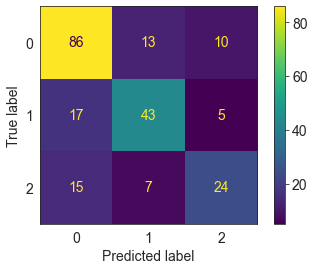

In [56]:
conf_m = confusion_matrix(test_labels, voting_c.predict(test_set))

sns.set_style('white')
disp = ConfusionMatrixDisplay(conf_m)
disp.plot()
plt.show()

Ensembling results in a significant improvement in performance.


# Experimenting with Neural Networks

<table align="left">
  <td>
    <a href="https://colab.research.google.com/drive/1ohG5S4XwqS0w5IdjkkTDh4Zc4BQ35xbH#scrollTo=31bc1dea" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>

* Since the last lectures of the course were focused on Neural Networks, I wanted to play around with them and see what performance I could obtain.

* The size of the dataset and the kind of features aren't really the setting in which NNs stand out, so the following is more of an exercise to start using PyTorch.

* Generally, it is recommended training neural networks on Google Colab, where GPU acceleration is available. However, the whole notebook should work properly on Jupyter Notebook as well.

**Important**:

* The following code is partly based on snippets found on Pytorch docs. 
* The Colab version features some minor adaptations for GPU compatibility.
* I experimented manually with the network structure in order to see what worked best. I did not want to dive into convolutions since we are not dealing with visual patterns and I don't really know what my data represents.

In [57]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [58]:
# !conda install -c nvidia cuda   #run this if cuda isn't available in your env.

In [59]:
if torch.cuda.is_available():
    print('running on GPU device')
    device = torch.device('cuda') # work with gpu if available
else:
    print('running on CPU device')
    device = torch.device('cpu') # work with cpu otherwise


running on CPU device


In [72]:
# loading data
X_train_nn = torch.tensor(strat_train_set.values).float().to(device)
X_test_nn = torch.tensor(strat_test_set.values).float().to(device)
y_train_nn = torch.tensor(train_labels.values).to(device)
y_test_nn = torch.tensor(test_labels.values).to(device)

In [73]:
#defining network structure
class Net(nn.Module):
    def __init__(self):  
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(30,20) # input layer
        self.linear2 = nn.Linear(20,10) # hidden layer
        self.linear_out = nn.Linear(10,3) # output layer
        self.activation = nn.ReLU()
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        x = self.softmax(self.li near_out(x)) #needed for multiclass
        return x
    

nn_clf = Net()

The inevitable choice for a loss function was the Cross Entropy, optimized through SGD.

In [74]:
opt = optim.SGD(nn_clf.parameters(), lr = 10)
loss_f = nn.CrossEntropyLoss()

def train_model(model, X, y, optimizer, loss, n_iter, verbose = False):
    
    for epoch in range(n_iter):
        optimizer.zero_grad() # reset gradient at the beginning

        yhat = model(X) # compute predictions

        loss = loss_f(yhat, y) # compute loss and gradient
        loss.backward()

        optimizer.step() # update weights
        
        if verbose and epoch % (n_iter/10) == 0: # report accuracy and loss at 10 epoch thresholds
            pred = torch.argmax(yhat, dim = 1)
            preds_check = pred.float() == y.float()
            accuracy = preds_check.sum().item() / len(preds_check)
            
            print('Epoch {:4d}/{} Loss: {:.6f} Accuracy {:2.2f}%'.format(
                epoch, n_iter, loss.item(), accuracy * 100,
            ))


In [75]:
train_model(nn_clf, X_train_nn, y_train_nn, opt, loss_f, n_iter = 1000, verbose = True)

Epoch    0/1000 Loss: 1.121534 Accuracy 23.07%
Epoch  100/1000 Loss: 0.692682 Accuracy 85.80%
Epoch  200/1000 Loss: 0.626659 Accuracy 92.39%
Epoch  300/1000 Loss: 0.624427 Accuracy 92.61%
Epoch  400/1000 Loss: 0.594540 Accuracy 95.68%
Epoch  500/1000 Loss: 0.587755 Accuracy 96.36%
Epoch  600/1000 Loss: 0.587726 Accuracy 96.36%
Epoch  700/1000 Loss: 0.587721 Accuracy 96.36%
Epoch  800/1000 Loss: 0.587720 Accuracy 96.36%
Epoch  900/1000 Loss: 0.587719 Accuracy 96.36%


After training, the parameters are stored in the model instance. Generalization performance follows.

In [76]:
test_preds = torch.argmax(nn_clf(X_test_nn), dim = 1).numpy()

print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       109
           1       0.74      0.78      0.76        65
           2       0.76      0.48      0.59        46

    accuracy                           0.76       220
   macro avg       0.76      0.71      0.72       220
weighted avg       0.76      0.76      0.76       220



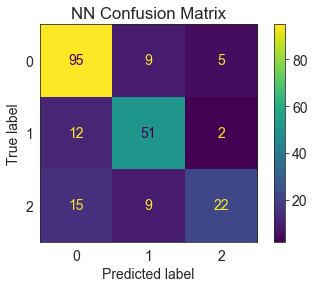

In [77]:
conf_m_nn = confusion_matrix(test_labels, test_preds)

disp = ConfusionMatrixDisplay(conf_m_nn)
disp.plot()
plt.title('NN Confusion Matrix')
plt.show()

The results are outstanding!

Our Neural Network Classifier achieves the best performance out of all tested estimators.